In [40]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import tensorflow  as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, Dropout, ZeroPadding2D, Flatten, Activation
from tensorflow.keras.optimizers import Adam

The aim of this notebook is to train a simple GAN architecture to generate art and detect, both qualitatively and quantitatively, if it hits a mode collapse

In [121]:
BATCH = 64
IMG_SIZE = (64,64)
LATENT_DIM = 100
EPOCHS = 600
PATH = "../input/abstract-art-gallery/Abstract_gallery/Abstract_gallery"

In [46]:
#Importing data
batch_s = int(BATCH/2)
#Import as tf.Dataset
data = tf.keras.preprocessing.image_dataset_from_directory(PATH, label_mode = None, image_size = IMG_SIZE, batch_size = batch_s).map(lambda x: x /255.0)

Found 2782 files belonging to 1 classes.


In [51]:
for sample in data:
    break

Below I have plotted a few images present in the training set. All images are reduced to (64,64) to reduce computational requirements

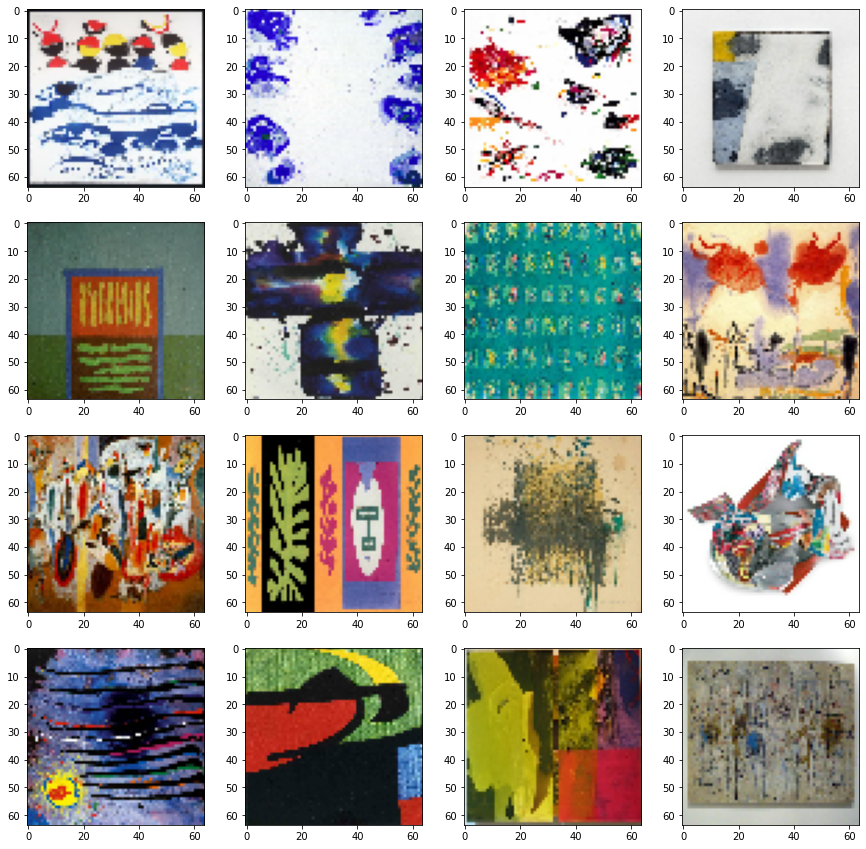

In [52]:
f,ax = plt.subplots(4,4,figsize=(15,15))
ax=ax.flatten()
for i in range(16):
    ax[i].imshow(sample[i])

## GENERATOR
The generator accepts a random 1D array (I've chosen a length of 100). The first dense layer expands the input and the subsequent reshape layer transforms it to a 3D tensor. Next, the tensor goes down a fully convolutional network, made up of multiple transposed convolutional layers, and metamorphisises into a 64,64 rgb image. All convup_blocks, instead of the last one, consist of a convolutional layer and an upsampling layer.

In [99]:
generator=Sequential()
generator.add(Dense(4*4*512,input_shape=[LATENT_DIM]))
generator.add(Reshape([4,4,512]))
generator.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding="same",
                                 activation='sigmoid'))

## DISCRIMINATOR
Generator's alter ego, the discriminator accepts an input image and identifies whether it's a real portrait. It consists of multiple convolutional layers followed by a dense layer and functions like a typical CNN classfier. Finally it assigns each image a score depending on how close they seem to have come from the real data distribution. Do note that the discriminator does not consist of any pooling layers. According to this 2015 [paper](http://https://arxiv.org/pdf/1511.06434.pdf) pooling layers in GANs should be replaced with strided convolutions.

In [100]:
discriminator=Sequential()
discriminator.add(Conv2D(32, kernel_size=4, strides=2, padding="same",input_shape=[64,64, 3]))
discriminator.add(Conv2D(64, kernel_size=4, strides=2, padding="same"))
discriminator.add(LeakyReLU(0.2))
discriminator.add(BatchNormalization())
discriminator.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
discriminator.add(LeakyReLU(0.2))
discriminator.add(BatchNormalization())
discriminator.add(Conv2D(256, kernel_size=4, strides=2, padding="same"))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Flatten())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1,activation='sigmoid'))

## GAN Training

When combined, the generator and the discriminator form a GAN. The two are trained in isolation Here's the training loop

#### Discriminator training

1. Generator creates fake images from a random array of length 100
2. The fake images are labelled as 1, while the real ones as 0. Some noise is added to the labels as regularization
3. Both sets of 32 images are merged and passed into the discriminator 
4. Using the labels, the discriminator learns to differentiate b/w real and fake images

#### Generator training

1. Generator recreates fake images from a random array of length. Here we generate 64 images to match the number of images passed into the generator previously
2. These fake images are labelled as 1 to confuse the discriminator
3. The fake images are passed to the discriminator which outputs scores indicating if the images are from real distribution
4. Based on the scores, gradients are computed to update the generator's weights

During generator training phase, the discriminator's weights aren't updated and vice versa. This training loop continues for a number of epochs. Ideally, the GAN is deemed as trained when the discrimnator gives an ouput of 0.5 regardless of the input image class. Basically, the quality of generated images improve to a point where the discriminator can't differentiate them from real images. However, due to a variety of reasons, this convergence is rarely, if ever, achieved.

In [101]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.dloss = tf.keras.metrics.Mean(name="discriminator_loss")
        self.gloss = tf.keras.metrics.Mean(name="generator_loss")

    @property
    def metrics(self):
        return [self.dloss, self.gloss]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(noise)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            dloss = self.loss_fn(labels, predictions)
        grads = tape.gradient(dloss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        noise = tf.random.normal(shape=(2*batch_size, self.latent_dim))
        labels = tf.zeros((2*batch_size, 1))
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(noise))
            gloss = self.loss_fn(labels, predictions)
        grads = tape.gradient(gloss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        self.dloss.update_state(dloss)
        self.gloss.update_state(gloss)
        return {"d_loss": self.dloss.result(), "g_loss": self.gloss.result()}

In [102]:

discriminator_opt = tf.keras.optimizers.Adam(1.5e-5,0.5)
generator_opt = tf.keras.optimizers.Adam(1.5e-5,0.5)
loss_fn = tf.keras.losses.BinaryCrossentropy()
model = GAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)
model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)

In [114]:
history=model.fit(data,epochs=200)

Epoch 1/200
87/87 [==============================] - 10s 108ms/step - d_loss: 0.6835 - g_loss: 0.7648
Epoch 2/200
87/87 [==============================] - 9s 98ms/step - d_loss: 0.6849 - g_loss: 0.7690
Epoch 3/200
87/87 [==============================] - 9s 97ms/step - d_loss: 0.6870 - g_loss: 0.7581
Epoch 4/200
87/87 [==============================] - 9s 98ms/step - d_loss: 0.6863 - g_loss: 0.7700
Epoch 5/200
87/87 [==============================] - 9s 94ms/step - d_loss: 0.6834 - g_loss: 0.7760
Epoch 6/200
87/87 [==============================] - 9s 93ms/step - d_loss: 0.6850 - g_loss: 0.7674
Epoch 7/200
87/87 [==============================] - 9s 95ms/step - d_loss: 0.6813 - g_loss: 0.7685
Epoch 8/200
87/87 [==============================] - 9s 94ms/step - d_loss: 0.6855 - g_loss: 0.7650
Epoch 9/200
87/87 [==============================] - 9s 100ms/step - d_loss: 0.6872 - g_loss: 0.7553
Epoch 10/200
87/87 [==============================] - 9s 97ms/step - d_loss: 0.6867 - g_loss: 0.7

## MODE COLLAPSE EVALUATION

A prominent issue with GANs is their inability to pick up all modes present in the training data. Suppose the generator manages to construct data of a particular mode well enough to fool the discriminator. It doesn't need to hustle anymore. The discriminator, though, during its training iteration will receive these generated images labelled as fake and over time learn to recognise them. When this happens, the generator could easily switch to some other mode and continue the mode collapse loop.

From the generator images plotted below,though,we seem to have avoided mode collapse. We'll dive deeper into how mode collapse can be gauged more quantitatively as qualitative inspection might be tedious when working with extremely large data

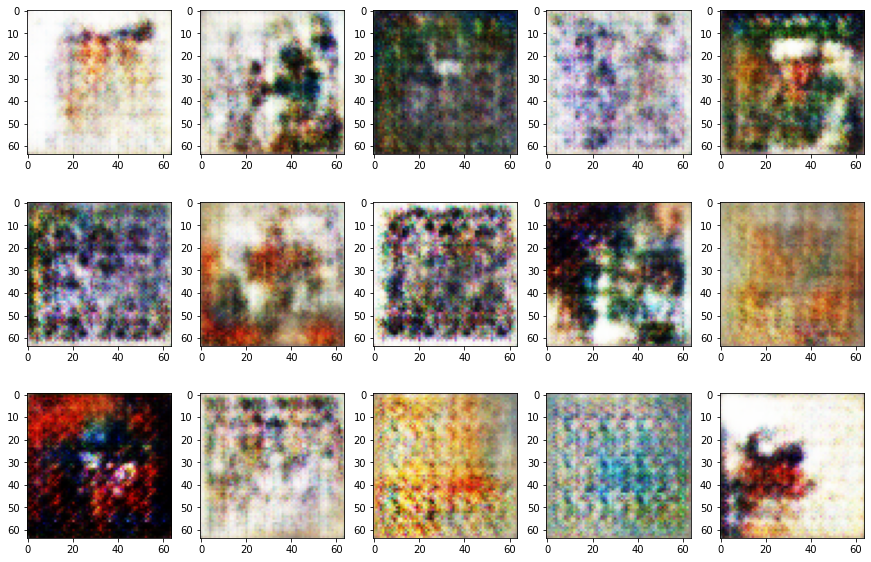

In [115]:
f,ax = plt.subplots(3,5,figsize=(15,10))
ax = ax.flatten()
arr = tf.random.normal(shape=(15, LATENT_DIM))
generated_portraits = model.generator(arr)
for i in range(15):
    g=generated_portraits[i]*255
    ax[i].imshow(tf.cast(g,tf.uint8))

In [116]:
from sklearn.cluster import KMeans

The first step is to cluster training images to find the optimal number of classes. This might not make sense on a qualitative level since all our images are random paintings(single class). Nevertheless, I expect the kmeans algorithm to identify subtle similarities amongst the portraits and create appropriate clusters. We'll iterate through our tf dataloader to create an array of all training images. We have rgb images of shape (64,64). To reduce dimensions, we'll average the arrays along the last axis to convert them to grayscale. Note that the actual formula for converting to grayscale is different. Refer this [link](!https://e2eml.school/convert_rgb_to_grayscale.html) for more information. 
We can further shrink the dimensions using autoencoders/PCA, but I'll not for now. Finally, for clustering, we'll also flatten the images

In [123]:
images = []
training = tf.keras.preprocessing.image_dataset_from_directory(PATH,label_mode=None ,image_size=IMG_SIZE, batch_size=batch_s).map(lambda x: x / 255.0)
for i,batch in enumerate(training):
    if i == len(training):
        break
    else:
        images.append(np.array(batch[0]))

Found 2782 files belonging to 1 classes.


In [124]:
images = np.asarray(images)
images = np.mean(images,axis=3)
images = images.reshape((images.shape[0],-1))

To save computational time, I've only used the first 500 images to create clusters. The elbow score is not quite plateauing yet. This is expected as all images are of the same class and hence the differences are subtle. Although, further reduction in image dimensionality might help create better clusters. For illustration, we'll make due with the kink at cluster 7.

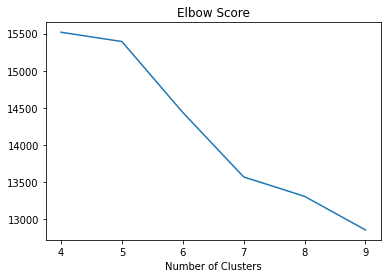

In [129]:
elbow_scores=[]
for c in range(4,10):
    kmeans = KMeans(c)
    kmeans.fit(images[:500])
    elbow_scores.append(kmeans.inertia_)

plt.plot(range(4,10),elbow_scores)
plt.xlabel('Number of Clusters')
plt.title('Elbow Score')
plt.show()

In [130]:
kmeans=KMeans(7)
train_classes=kmeans.fit_predict(images[:500])

Now,we'll generate 100 images from the generator, and see which clusters they fall into.

In [132]:
arr = tf.random.normal(shape=(500,LATENT_DIM))
generated_portraits = generator(arr)
generated_portraits = np.array(generated_portraits).mean(axis=3).reshape((generated_portraits.shape[0],-1))
generated_classes = kmeans.predict(generated_portraits)

We seem to have generated images from all but cluster 4. This is nice, the GAN seems to be learning the distribution well and could possibly do better with more training iterations, or hyperparameter tuning. Now, we'll expand this evaluation to create a more concrete statstical test.

In [133]:
generated_classes

array([6, 1, 5, 1, 2, 0, 2, 0, 0, 3, 1, 6, 0, 6, 0, 5, 0, 0, 0, 5, 3, 5,
       0, 5, 0, 5, 2, 5, 5, 0, 0, 3, 0, 5, 0, 0, 3, 0, 0, 5, 0, 0, 6, 3,
       1, 3, 1, 1, 5, 6, 3, 5, 0, 6, 5, 0, 3, 5, 1, 0, 0, 5, 5, 5, 0, 0,
       1, 5, 3, 5, 6, 5, 3, 5, 0, 1, 0, 2, 5, 5, 5, 0, 0, 1, 6, 0, 1, 5,
       5, 1, 5, 1, 5, 5, 6, 6, 5, 0, 5, 5, 0, 5, 3, 0, 1, 3, 0, 0, 1, 1,
       6, 6, 1, 5, 6, 5, 5, 0, 0, 1, 0, 1, 0, 3, 6, 1, 0, 5, 6, 0, 0, 5,
       0, 1, 5, 5, 1, 5, 3, 0, 0, 0, 5, 5, 6, 0, 2, 5, 1, 6, 1, 0, 3, 0,
       1, 1, 1, 1, 5, 5, 0, 5, 5, 5, 5, 3, 0, 5, 3, 3, 6, 5, 1, 5, 5, 6,
       1, 0, 2, 1, 3, 5, 5, 5, 0, 6, 3, 1, 5, 5, 1, 0, 2, 1, 0, 0, 5, 5,
       0, 5, 0, 5, 0, 1, 6, 5, 0, 1, 6, 5, 0, 2, 0, 5, 0, 1, 5, 0, 0, 6,
       0, 5, 2, 5, 0, 6, 5, 5, 1, 1, 0, 6, 0, 5, 3, 1, 3, 0, 6, 0, 5, 1,
       1, 0, 1, 0, 6, 5, 0, 0, 1, 0, 2, 0, 5, 6, 5, 5, 1, 3, 5, 5, 6, 1,
       5, 6, 0, 0, 6, 0, 6, 5, 3, 5, 0, 5, 5, 1, 0, 0, 0, 5, 0, 3, 0, 5,
       3, 5, 5, 0, 1, 0, 0, 0, 1, 6, 6, 6, 0, 1, 6,

## NDB Score

The ideal GAN should learn a probability distribution that closely mimics the training data distribution. This is quantified using NDB score. Here's how its computed:

1. Cluster the training data (t samples) into 'n' bins (Like we have clustered the portraits into 7 bins)
2. Generate (g samples) of images
3. Predict the cluster(bin) of each generated image
4. For each bin do the following test:

    4.1 Compute the proportions of training and generated samples in the bin
    4.2 Divide their difference by the standard error SE which is calculated as shown below. Here 'p' and 'q' are used to refer training and generated data, and 'P' is the pooled sample proportion
    4.3 If the p-value corresponding to the z-score is less than a threshold, the bin is deemed statistically different

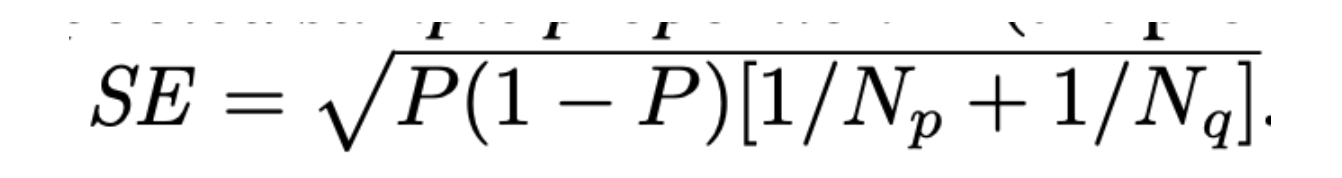

5. Divide the number of statistically different bins by the number of bins. This'll give a number b/w 0 and 1 quantifying the difference between the real and learned distributions.
6. If '5'(the above quantity) is greater than a set threshold, the GAN is deemed to have encountered mode collapse.

Please refer these links for more details:

1. https://www.google.com/search?q=ndb+score+gan&oq=ndb+&aqs=chrome.0.69i59j69i57j46i199i465i512j46i175i199i512j0i512j0i433i512j0i512j69i60.1083j0j7&sourceid=chrome&ie=UTF-8

2. https://arxiv.org/abs/1805.12462

In [134]:
def ndb_score(training_data_classes,generated_data_classes,num_classes,z_threshold):
    ndb = []
    NT = len(training_data_classes)
    NG = len(generated_data_classes)
    for i in range(num_classes):
        nt = np.sum(training_data_classes==i)
        pt = nt/len(training_data_classes) #training data proportion for bin
        ng = np.sum(generated_data_classes==i)
        pg = ng/len(generated_data_classes) #generated data proportion for bin
        P = (nt+ng)/(NT+NG)
        SE = (P*(1-P)*((1/NT)+(1/NG)))**0.5
        if abs((pt-pg)/SE) > z_threshold:
            ndb.append(i)
    print(f"Statisticall different classes:{ndb}")
    print(f"ndb score: {len(ndb)/num_classes}")

In [135]:
ndb_score(train_classes,generated_classes,8,1.96)

Statisticall different classes:[4, 5]
ndb score: 0.25


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


Our GAN has an NDB score of 0.25 and only two clusters-4,5-seem to be statistically different from the real distribution.

In [137]:
model.save_weights("ART_GAN.h5")

Please upvote if you liked the illustration on NDB score. Thanks!

## References
1. https://www.google.com/search?q=ndb+score+gan&oq=ndb+&aqs=chrome.0.69i59j69i57j46i199i465i512j46i175i199i512j0i512j0i433i512j0i512j69i60.1083j0j7&sourceid=chrome&ie=UTF-8

2. https://arxiv.org/abs/1805.12462

3. https://www.kaggle.com/code/karnikakapoor/art-by-gan